 # Build the decision tree with Python

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# this function displays the split of the tree
from sklearn.tree import plot_tree

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

In [13]:
data = pd.read_csv('/Users/cansezgin/Downloads/Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [15]:
# check class balance
data['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

The class of our target variable is split roughly 80/20. In other words, ~20% of the people in this dataset churned. This is an unbalanced dataset, but it's not extreme. We will preserve this ratio when we model.

# Select an evaluation metric

In [23]:
# calculate average balance of customers who churned
avg_churned_bal = data[data['Exited'] == 1]['Balance'].mean()
avg_churned_bal

91108.53933726068

# Feature engineering

In [27]:
## Feature Selection
# create a new data frame that drops RowNumber, CustomerId, Surname , and Gender cols
churn_df = data.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'],
                     axis = 1)

In [29]:
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


In [31]:
## Feature Transformation
# Dummy encode categorical variables
churn_df = pd.get_dummies(churn_df, drop_first = True)

In [33]:
churn_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True


# Split Data

It's time to split the data into features and target variable, and into training data and test data. We do this using the train_test_split() function. We'll put 25% of the data into our test set, and use the remaining 75% to train the model.

Don't forget to include the stratify=y parameter, as this is what ensures that the 80/20 class ratio of the target variable is maintained in both the training and test datasets after splitting.

Lastly, we set a random seed so we and others can reproduce our work.

In [82]:
# define the y(target) variable
y = churn_df['Exited']

# define the X (predictor) variables
X = churn_df.copy()
X = X.drop('Exited', axis = 1)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25, stratify = y,
                                                    random_state = 42)

# Baseline Model

We'll first train a baseline model, just to get a sense of how predictive the data is and to give us scores that we can reference later. 

This will also show the process of instantiating and fitting the model, and then using it to make predictions. We'll predict on the test data.

In [86]:
# instatiate the model
decision_tree = DecisionTreeClassifier(random_state = 0)

# fit the model to train data
decision_tree.fit(X_train, y_train)

# Make predictions on test data
dt_pred = decision_tree.predict(X_test)

In [88]:
# Generate performance metrics
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("f1 score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.790
Precision: 0.486
Recall: 0.503
f1 score: 0.494


# Analysis of Baseline Model

In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def conf_matrix_plot(model, x_data, y_data):
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format='')
    plt.show()

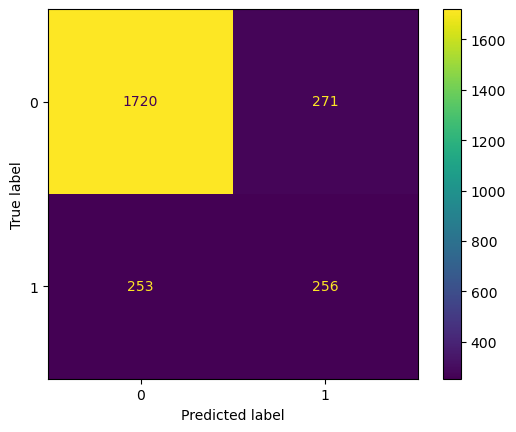

In [107]:
# genetate confusion matrix
conf_matrix_plot(decision_tree, X_test, y_test)

Notice from this confusion matrix that the model correctly predicts many true negatives. Of course, this is to be expected, given that the dataset is imbalanced in favor of negatives. When the model makes an error, it appears slightly more likely to predict a false positive than a false negative, but it's generally balanced. This is reflected in the precision and recall scores both being very close to each other.

## Plotting the Tree

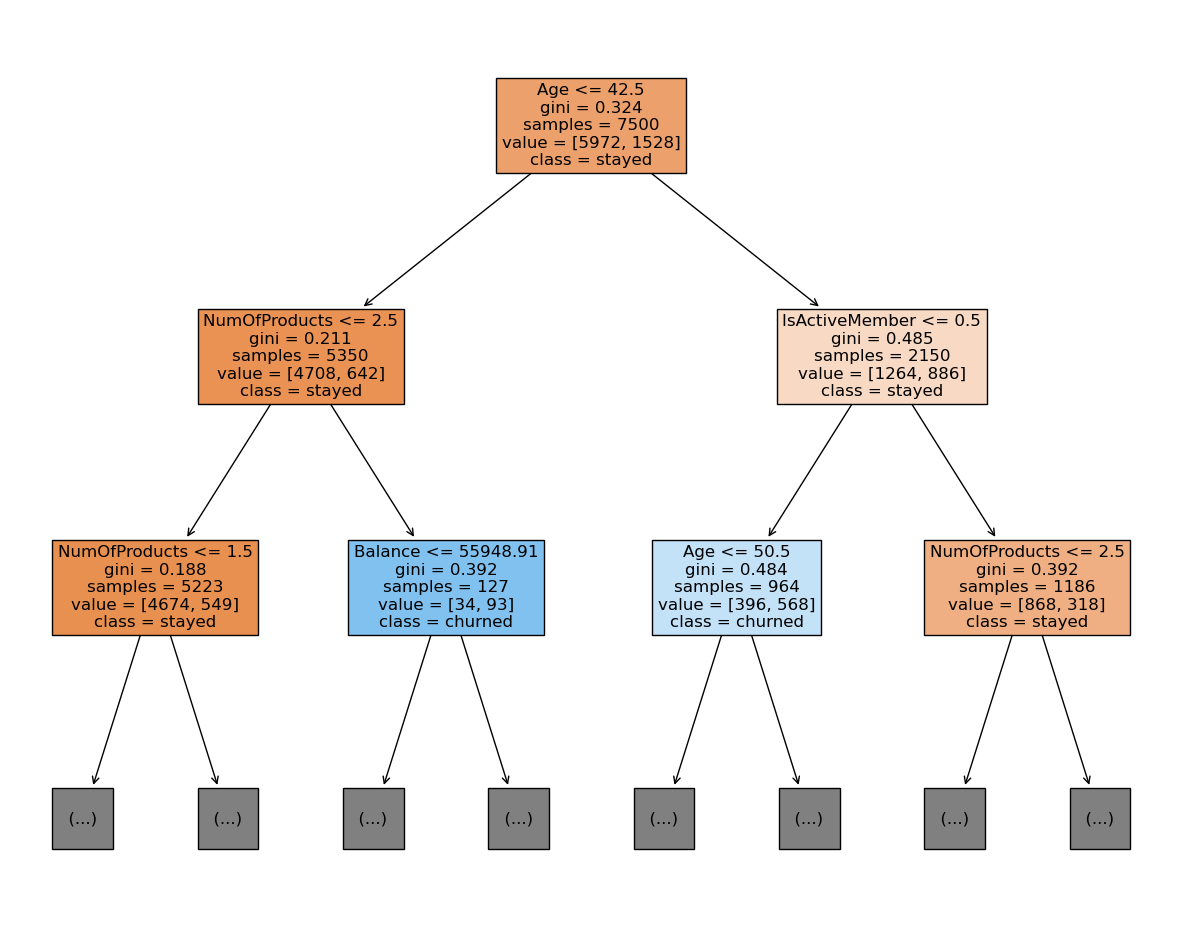

In [123]:
# plot the tree
plt.figure(figsize = (15,12))
plot_tree(decision_tree, max_depth = 2, fontsize = 12, feature_names = X.columns,
          class_names = {0: 'stayed', 1:'churned'}, filled = True);
plt.show()

This plot tells us that, if we could only do a single split on a single variable, the one that would most help us predict whether a customer will churn is their age.

If we look at the nodes at depth one, we notice that the number of products and whether or not the customer is an active member also are both strong predictors (relative to the features we have) of whether or not they will churn.